In [1]:
num_docs = 10000
num_ideal_points = 1
vocab_size = 10000
num_covs = 1
min_words = 200
max_words = 300

In [2]:
import numpy as np
from tqdm import tqdm

def generate_documents(
    num_docs, 
    num_ideal_points, 
    vocab_size, 
    num_covs,
    lambda_, 
    sigma,
    min_words=50, 
    max_words=100, 
    random_seed=42
):

    if random_seed is not None:
        np.random.seed(random_seed)

    if num_covs > 0:
        M_prevalence_covariates = np.zeros((num_docs, num_covs + 1), dtype=int)
        M_prevalence_covariates[:, 0] = 1
        for i in range(num_covs):
            M_prevalence_covariates[:, i + 1] = np.random.randint(2, size=num_docs)     
            
        mean = np.dot(M_prevalence_covariates, lambda_)
        samples = []
        for m in mean:
            sample = np.random.multivariate_normal(m, sigma)
            samples.append(sample)
        true_ideal_points = np.array(samples)

    else:
        M_prevalence_covariates = None
        true_ideal_points = np.random.normal(size=(num_docs, num_ideal_points))
        
    ideal_point_word_matrix = np.random.rand(num_ideal_points, vocab_size)
    
    documents = []

    for i in tqdm(range(num_docs)):
        doc_length = np.random.randint(min_words, max_words+1)
        doc_ideal_points = true_ideal_points[i]

        doc_words = []
        for _ in range(doc_length):
            word_probs = np.dot(doc_ideal_points, ideal_point_word_matrix)
            word_probs = np.exp(word_probs) / np.sum(np.exp(word_probs))  
            word_index = np.random.choice(vocab_size, p=word_probs.flatten())
            doc_words.append('word_' + str(word_index))

        doc_words = ' '.join(doc_words)
        documents.append(doc_words)

    return true_ideal_points, M_prevalence_covariates, documents

if num_covs > 0:
    np.random.seed(1)
    lambda_ = np.array(
        [[0],[1]]
    )
    sqrt_sigma = np.random.rand(num_ideal_points, num_ideal_points)
    sigma = sqrt_sigma * sqrt_sigma.T
    
    true_ideal_points, M_prevalence_covariates, documents = generate_documents(
        num_docs, num_ideal_points, vocab_size, num_covs, lambda_, sigma, min_words, max_words
    )
else:
    true_ideal_points, M_prevalence_covariates, documents = generate_documents(
        num_docs, num_ideal_points, vocab_size, num_covs = 0, lambda_ = None, sigma = None, min_words = min_words, max_words = max_words
    )

100%|██████████| 10000/10000 [24:35<00:00,  6.78it/s]


In [3]:
import pandas as pd

df = pd.DataFrame({"doc_clean": documents, "doc": documents})
if num_covs > 0:
    df['cov_0'] = 1
    df['cov_1'] = M_prevalence_covariates[:,1]
df

,doc_clean,doc,cov_0,cov_1
0,word_3289 word_3067 word_9875 word_6820 word_3...,word_3289 word_3067 word_9875 word_6820 word_3...,1,0
1,word_8433 word_1241 word_1235 word_1201 word_4...,word_8433 word_1241 word_1235 word_1201 word_4...,1,1
2,word_5144 word_5925 word_961 word_4779 word_99...,word_5144 word_5925 word_961 word_4779 word_99...,1,0
3,word_3765 word_1587 word_5851 word_1960 word_4...,word_3765 word_1587 word_5851 word_1960 word_4...,1,0
4,word_8333 word_7765 word_7551 word_8157 word_2...,word_8333 word_7765 word_7551 word_8157 word_2...,1,0
...,...,...,...,...
9995,word_7326 word_7042 word_6801 word_1527 word_9...,word_7326 word_7042 word_6801 word_1527 word_9...,1,1
9996,word_604 word_6045 word_8412 word_3109 word_99...,word_604 word_6045 word_8412 word_3109 word_99...,1,0
9997,word_3854 word_1354 word_4416 word_2052 word_5...,word_3854 word_1354 word_4416 word_2052 word_5...,1,1
9998,word_5762 word_1288 word_9654 word_4612 word_2...,word_5762 word_1288 word_9654 word_4612 word_2...,1,1


In [7]:
import sys
sys.path.append('../IdealPointNN/')
from corpus import IdealPointCorpus
from ideal_point_model import IdealPointNN

if num_covs > 0:
    train_dataset = IdealPointCorpus(
        df,
        prevalence = "~ cov_0 + cov_1 - 1",
    )
    m = IdealPointNN(
        train_dataset, 
        n_dims=1,
        update_prior=True,
        encoder_hidden_layers=[],
        decoder_hidden_layers=[],
        log_every_n_epochs = 1,
        print_every_n_batches = 100,
        dropout = 0
    )
else:
    train_dataset = IdealPointCorpus(
        df
    )
    m = IdealPointNN(
        train_dataset, 
        n_dims=1,
        update_prior=False,
        encoder_hidden_layers=[],
        decoder_hidden_layers=[],
        log_every_n_epochs = 1,
        print_every_n_batches = 10
    )

Epoch   1	Iter  100	Mean Training Loss:2571.7919922
Mean Rec Loss:2376.6359863
MMD Loss:195.1559143
Mean Pred Loss:0.0000000


Epoch   1	Mean Training Loss:3820.5968056

Epoch   2	Iter  100	Mean Training Loss:2488.0136719
Mean Rec Loss:2334.6347656
MMD Loss:153.3787842
Mean Pred Loss:0.0000000


Epoch   2	Mean Training Loss:2486.9181771

Epoch   3	Iter  100	Mean Training Loss:2657.5390625
Mean Rec Loss:2368.7817383
MMD Loss:288.7573853
Mean Pred Loss:0.0000000


Epoch   3	Mean Training Loss:2477.9384999

Epoch   4	Iter  100	Mean Training Loss:2572.5761719
Mean Rec Loss:2369.9079590
MMD Loss:202.6680908
Mean Pred Loss:0.0000000


Epoch   4	Mean Training Loss:2453.0711553

Epoch   5	Iter  100	Mean Training Loss:2514.0617676
Mean Rec Loss:2323.4211426
MMD Loss:190.6405487
Mean Pred Loss:0.0000000


Epoch   5	Mean Training Loss:2463.2996632

Early stopping at Epoch 5. Reverting to Epoch 4


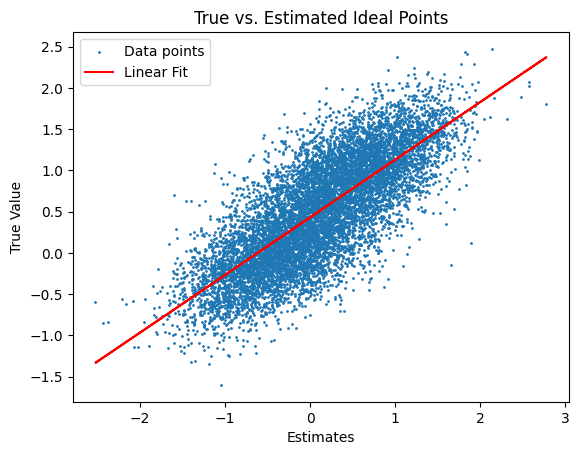

In [8]:
import numpy as np
import matplotlib.pyplot as plt

doc_dims = m.get_doc_dims(train_dataset)

x = doc_dims
y = true_ideal_points

plt.scatter(x, y, label='Data points', s=1)
coefficients = np.polyfit(x.flatten(), y.flatten(), 1)
fit = np.poly1d(coefficients)
plt.plot(x, fit(x), color='red', label='Linear Fit')
plt.xlabel('Estimates')
plt.ylabel('True Value')
plt.title('True vs. Estimated Ideal Points')
plt.legend()
plt.show()

In [10]:
if num_covs > 0:
    print('True lambda: {}'.format(lambda_))
    print('Estimated lambda: {}'.format(m.prior.lambda_))

True lambda: [[0]
 [1]]
Estimated lambda: tensor([[-0.3359],
        [ 0.8595]], device='cuda:0')
